In [2]:
%matplotlib inline

import sys
# locate your spectralCV so we have scv_funcs to use
sys.path.append('/Users/ldliao/Research/Projects/spectralCA/')

In [3]:
# imports
import os
import numpy as np
import scipy as sp
import scipy.io as io
import matplotlib.pyplot as plt
import pandas as pd
import mne

from sca import sca

## KJM data

In [3]:
def get_trial_info(cue_sig, move_sig, L_win=1000, L_lag=2000, alpha=0.95):
    # stim_info vector: [trial onset, movement onset, trial type, RT, premove duration, move duration]
    trial_init = np.where(np.diff((cue_sig>0).astype(int))==1)[0]+1
    move_init = np.where(np.diff((move_sig>0).astype(int))==1)[0]+1 
    trial_info = []
    for i, tr_onset in enumerate(trial_init):
        # pre-movement length
        L_premove = np.sum(move_sig[tr_onset-L_win:tr_onset]<=0)    
        # find corresponding movement onset time
        try:
            # if this fails, it means there was no response on the last trial
            mv_onset = move_init[np.where(move_init>tr_onset)[0][0]]        
            L_move = np.sum(move_sig[mv_onset:mv_onset+L_win]>0)
            # if 3 conditions are satisfied, add trial
            if L_premove/L_win>alpha and L_move/L_win>alpha and (mv_onset-tr_onset)<L_lag:
                RT = mv_onset-tr_onset
                trial_info.append([tr_onset, mv_onset, move_sig[mv_onset], RT, L_premove, L_move])
        except:
            print('Skipped last trial.')
    return np.array(trial_info)

def sca_kjm(data_path, subj, fs, analysis_param):
    # load data & trial info
    stim_info = io.loadmat(data_path+'data/'+subj+'/'+subj+'_stim.mat', squeeze_me=True)
    data = io.loadmat(data_path+'data/'+subj+'/'+subj+'_fingerflex.mat', squeeze_me=True)
    ecog = data['data'].T
    
    # set parameters
    win_len = int(fs)
    num_chan = ecog.shape[0]
    max_freq = analysis_param['max_freq']
    
    # sort out trial info
    trial_info = get_trial_info(data['cue'], stim_info['stim'], L_win=win_len, L_lag=1500, alpha=0.9)
    num_trials = trial_info.shape[0]
    print('%i included trials.'%num_trials)
        
    if num_trials>20:
        # pre-initialize arrays
        psd_precomp = np.zeros((num_chan, max_freq, num_trials, 2))

        # precompute trial PSDs
        for tr in range(num_trials):
            tr_onset = trial_info[tr,0]
            mv_onset = trial_info[tr,1]
            # pre-movement
            f_axis, t_axis, spg = sp.signal.spectrogram(ecog[:,tr_onset-win_len:tr_onset],fs=fs,nperseg=win_len)
            p_ = np.mean(spg,axis=-1)      
            psd_precomp[:,:,tr,0] = p_[:,:max_freq]
            # movement
            f_axis, t_axis, spg = sp.signal.spectrogram(ecog[:,mv_onset:mv_onset+win_len],fs=fs,nperseg=win_len)
            p_ = np.mean(spg,axis=-1)   
            psd_precomp[:,:,tr,1] = p_[:,:max_freq]

        sca_all = []
        for i in range(2):
            mov_sca = sca.SCA(analysis_param)
            mov_sca.populate_fourier_data(psd_precomp[:,:,:,i], fs, f_axis)
            mov_sca.compute_psd()
            mov_sca.compute_scv()
            sca_all.append(mov_sca)

        # return the pre- and during-movement sca data, and trial info
        return sca_all, trial_info
    else:
        return None, None

In [4]:
# define data folder
data_path = '/Users/ldliao/Research/Data/ECoG_KJM/digit/'
saveout_path = '../results/kjm_digits/'
save_files = ['pre','move','whole']
subjs = ['bp', 'cc', 'ht', 'jc', 'jp', 'mv', 'wc', 'wm', 'zt']

# electrode location
elec_def = [('0', 'dorsal_M1'),
            ('1', 'dorsal_S1'),
            ('2', 'ventral_S1+M1'),
            ('3', 'frontal_(non-R)'),
            ('4', 'parietal_(non-R)'),
            ('5', 'temporal'),
            ('6', 'occipital')]

In [5]:
fs = 1000.
# sca params
analysis_param = {'nperseg': 1000,
                 'noverlap': 0,
                 'spg_outlierpct': 2.,
                 'max_freq':200}

for subj in subjs:
    print(subj)
    # get the trial-separated sca
    sca_all, trial_info = sca_kjm(data_path,subj,fs,analysis_param)
    if sca_all is not None:
        # get sca for whole recording
        data = io.loadmat(data_path+'data/'+subj+'/'+subj+'_fingerflex.mat', squeeze_me=True)    
        sca_all.append(sca.SCA(analysis_param))
        sca_all[-1].populate_ts_data(data['data'].T, fs)
        sca_all[-1].compute_all_spectral()

        # make dir
        subj_path = saveout_path+subj+'/'
        if not os.path.isdir(subj_path):
            os.mkdir(subj_path)

        print('Computing exponential KS test...')
        for ind, sc in enumerate(sca_all):
            # compute fit
            sc.compute_KS_expfit()
            # save channel labels
            sc.chan_labels = ['chan_' + key + '_' + val for (key, val) in elec_def]
#             print(ind)
#             sc.cross_freq_corr()
            # save out sca         
            sc.save_spec_vars(subj_path+save_files[ind]+'.npz', save_spg=True)

        # save trial info and plot contrast
        np.savez(subj_path+'trial_info.npz', trial_info=trial_info, elec_regions=data['elec_regions'])
    else:
        print('Skipped subject.')

bp
103 included trials.
Computing exponential KS test...
cc
63 included trials.
Computing exponential KS test...
ht
84 included trials.
Computing exponential KS test...
jc
Skipped last trial.
107 included trials.
Computing exponential KS test...
jp
Skipped last trial.
Skipped last trial.
7 included trials.
Skipped subject.
mv
0 included trials.
Skipped subject.
wc
39 included trials.
Computing exponential KS test...
wm
Skipped last trial.
Skipped last trial.
29 included trials.
Computing exponential KS test...
zt
33 included trials.
Computing exponential KS test...


## Hermes Data

In [6]:
import bids


subj, sess, run = '01', '01', 1
layout = bids.layout.BIDSLayout('/Users/ldliao/Research/Data/Hermes_VCECoG/')
f_raw = layout.get(return_type='object', suffix='ieeg', subject=subj, session=sess, run=run, extensions='.vhdr')[0]
f_events = layout.get(return_type='object', suffix='events', subject=subj, session=sess, run=run)[0]
f_channels = layout.get(return_type='object', suffix='channels', subject=subj, session=sess, run=run)[0]
f_elec = layout.get(return_type='object', suffix='electrodes', subject=subj, session=sess)[0]

events = pd.read_csv(f_events.path, delimiter='\t')
chan_info = pd.read_csv(f_channels.path, delimiter='\t')
elec_loc = pd.read_csv(f_elec.path, delimiter='\t').apply(pd.to_numeric, errors='coerce')

/anaconda3/envs/voytek/lib/python3.6/site-packages/bids/layout/layout.py:665: UserWarning: In pybids 0.9.0, the 'extensions' filter was deprecated in favor of 'extension'. The former will stop working in 0.11.0.
  warnings.warn("In pybids 0.9.0, the 'extensions' filter was "


In [7]:
layout.get_metadata(f_raw.path)

{'ECGChannelCount': 0,
 'ECOGChannelCount': 118,
 'EEGChannelCount': 0,
 'EMGChannelCount': 0,
 'EOGChannelCount': 0,
 'ElectrodeManufacturer': 'AdTech',
 'EpochLength': 0,
 'HardwareFilters': ['highpass', '0.5', 'lowpass', '300'],
 'InstitutionAddress': '300 Pasteur Dr, Stanford, CA 94305',
 'InstitutionName': 'Stanford Hospital and Clinics',
 'Instructions': 'look at the dot in the center of the screen and press the button when it changes color',
 'Manufacturer': 'Tucker Davis Technologies',
 'MiscChannelCount': 0,
 'PowerLineFrequency': 60,
 'RecordingDuration': 233.639,
 'RecordingType': 'continuous',
 'SEEGChannelCount': 0,
 'SamplingFrequency': 3051.76,
 'SoftwareFilters': 'n/a',
 'TaskDescription': 'visual gratings and noise patterns',
 'TaskName': 'visual',
 'TriggerChannelCount': 0,
 'iEEGPlacementScheme': 'right occipital temporal surface',
 'iEEGReferenceScheme': 'intracranial channel not included with data'}

In [8]:
layout.get(return_type='filename')

['/Users/ldliao/Research/Data/Hermes_VCECoG/CHANGES',
 '/Users/ldliao/Research/Data/Hermes_VCECoG/dataset_description.json',
 '/Users/ldliao/Research/Data/Hermes_VCECoG/participants.tsv',
 '/Users/ldliao/Research/Data/Hermes_VCECoG/README',
 '/Users/ldliao/Research/Data/Hermes_VCECoG/stimuli/.DS_Store',
 '/Users/ldliao/Research/Data/Hermes_VCECoG/stimuli/sub-01_png/stim_1.png',
 '/Users/ldliao/Research/Data/Hermes_VCECoG/stimuli/sub-01_png/stim_2.png',
 '/Users/ldliao/Research/Data/Hermes_VCECoG/stimuli/sub-01_png/stim_3.png',
 '/Users/ldliao/Research/Data/Hermes_VCECoG/stimuli/sub-01_png/stim_4.png',
 '/Users/ldliao/Research/Data/Hermes_VCECoG/stimuli/sub-01_png/stim_5.png',
 '/Users/ldliao/Research/Data/Hermes_VCECoG/stimuli/sub-01_png/stim_6.png',
 '/Users/ldliao/Research/Data/Hermes_VCECoG/stimuli/sub-01_png/stim_7.png',
 '/Users/ldliao/Research/Data/Hermes_VCECoG/stimuli/sub-01_png/stim_8.png',
 '/Users/ldliao/Research/Data/Hermes_VCECoG/stimuli/sub-01_png/stim_9.png',
 '/Users/ld

In [9]:
mne.__version__

'0.18.2'

In [10]:
mne

<module 'mne' from '/anaconda3/envs/voytek/lib/python3.6/site-packages/mne/__init__.py'>

In [11]:
raw = mne.io.read_raw_brainvision(f_raw.path)
raw.info
data, t = raw[:,:]
data = data[:-1,:]

Extracting parameters from /Users/ldliao/Research/Data/Hermes_VCECoG/sub-01/ses-01/ieeg/sub-01_ses-01_task-visual_run-01_ieeg.vhdr...
Setting channel info structure...


AttributeError: 'NoneType' object has no attribute 'strip'

## MNI rest ECoG data

In [4]:
data_path = '/Users/ldliao/Research/Data/MNI_rest_ECoG/WakefulnessMatlabFile.mat'
data = io.loadmat(data_path, squeeze_me=True)    
saveout_path = '/Users/ldliao/Research/Projects/spectralCA/results/mni_rest/'

fs = data['SamplingFrequency']
# sca params
analysis_param = {'nperseg': 200,
                 'noverlap': 0,
                 'spg_outlierpct': 2.,
                 'max_freq':200}

In [5]:
import scipy as sp

In [85]:
data_path = '/Users/ldliao/Research/Data/MNI_rest_ECoG/WakefulnessMatlabFile.mat'
data = io.loadmat(data_path, squeeze_me=True)    
saveout_path = '/Users/ldliao/Research/Projects/spectralCA/results/mni_rest/'

fs = data['SamplingFrequency']
# sca params
analysis_param = {'nperseg': 200,
                 'noverlap': 0,
                 'spg_outlierpct': 2.,
                 'max_freq':200}

patient = data['Patient']

# getting the different indices start
ind = [ind for ind in np.where(patient[:-1] != patient[1:])[0]]
ind.insert(0,0) 

# make dir
subj_path = saveout_path
if not os.path.isdir(subj_path):
    os.mkdir(subj_path)


for idx in range(1):#(len(ind)-1):
    sub_data = data['Data'][ind[idx]:ind[idx+1]].T
    sub_chanlab = data['ChannelName'][ind[idx]:ind[idx+1]].T
    sub_chanlab = ['chan_'+str(i)+'_'+ch for i, ch in enumerate(sub_chanlab)]
            
    sub_sc = sca.SCA(analysis_param)
    sub_sc.populate_ts_data(sub_data, fs)
    sub_f_axis, sub_t_axis, sub_spg = sp.signal.spectrogram(sub_data, sub_sc.fs, 'hann', 
                                                            sub_sc.nperseg, sub_sc.noverlap, mode='complex')
    sub_sc.populate_spg(sub_f_axis, sub_t_axis, sub_spg)
    sub_sc.compute_all_spectral()

    
    print('Computing exponential KS test...')

    sub_sc.compute_KS_expfit()
    # save channel labels
    sub_sc.chan_labels = sub_chanlab
    sub_sc.cross_freq_corr()
        
    # save out sca      
    #sub_path = saveout_path+'patient_'+str(data['Patient'][ind[idx]])
    #sub_sc.save_spec_vars(sub_path+'.npz', save_spg=True)

/anaconda3/envs/voytek/lib/python3.6/site-packages/scipy/signal/spectral.py:1773: UserWarning: nperseg = 200 is greater than input length  = 13, using nperseg = 13
  .format(nperseg, input_length))


Computing exponential KS test...


/anaconda3/envs/voytek/lib/python3.6/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


In [86]:
sub_data.shape

(1772, 13)

In [79]:
print(sub_chanlab)

['chan_0_GD001Lc_11', 'chan_1_GD001Lc_12', 'chan_2_GD001Lc_13', 'chan_3_GD001Lc_14', 'chan_4_GD001Lo_1', 'chan_5_GD001Lo_2', 'chan_6_GD001Lo_3', 'chan_7_GD001Lo_4', 'chan_8_GD001Lv_1', 'chan_9_GD001Lv_2', 'chan_10_GD001Lv_3', 'chan_11_GD001Lv_4', 'chan_12_GD001Lv_5']


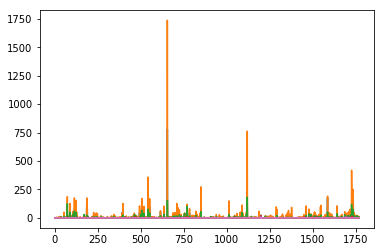

In [89]:
import matplotlib.pyplot as plt
plt.plot(sub_sc.psd)

In [8]:
fs = data['SamplingFrequency']

In [9]:
fs

200

array([  1,   1,   1, ..., 110, 110, 110], dtype=uint8)